In [1]:
# Import packages
import numpy as np
from skimage.segmentation import slic
from skimage.transform import resize
from skimage.filters import gaussian
from PIL import Image
import matplotlib.pyplot as plt

# Import samplers
from samplers import RandomSampler, SingleFeatureSampler, ShapSampler
# Import explainers
from explainers import OriginalCIUAttributer, SHAPAttributer, RISEAttributer
# Import segmenters
from image_segmenters import GridSegmenter, WrapperSegmenter
# Import segmentation and perturbation utils
from image_segmenters import FadeMaskTransformer, perturbation_masks
# Import image perturbers
from image_perturbers import SingleColorPerturber, ReplaceImagePerturber, TransformPerturber, RandomColorPerturber
# Import connectors
from connectors import SegmentationAttribuitionPipeline
# Import image explanation visualizers
from image_visualizers import TopVisualizer, HeatmapVisualizer
# Import PyTorch utils
from torch_utils import TorchModelWrapper, ImageToTorch
# Import explanation evaluators
from evaluation import auc_sampler, ImageAUCEvaluator

# Set seed for reproducibility (due to random noise used later)
np.random.seed(0)

In [2]:
# Collecting the image and resizing to fit later model input
img = resize(np.array(Image.open('images/LabradorPlayingGuitar.jpg')), (224,224,3))

# Create the segmenters, samplers, perturbers, and explainers
grid_segmenter = GridSegmenter(10, 10, bilinear=False)
slic_segmenter = WrapperSegmenter(slic, n_segments=50, compactness=10, start_label=0)

shap_sampler = ShapSampler()
ciu_sampler  = SingleFeatureSampler(add_none=True)
rise_sampler = RandomSampler()

gray_perturbation = SingleColorPerturber(color=np.array((190,190,190)))
blur_perturbation = TransformPerturber(gaussian, sigma=10)
rand_img = np.random.rand(*img.shape) # Create a random noisy image to replace masked pixels with
noise_perturbation = ReplaceImagePerturber(rand_img)

shap_values = SHAPAttributer()
original_ciu_values = OriginalCIUAttributer()
rise_values = RISEAttributer()

# TODO: Solve faded_gird_mask problem
faded_grid_masks = FadeMaskTransformer(sigma=10)

NameError: name 'slic' is not defined

In [ ]:
# Create the three attribution pipelines
slic_gray_shap_pipeline = SegmentationAttribuitionPipeline(
    segmenter=slic_segmenter, sampler=shap_sampler,
    perturber=gray_perturbation, explainer=shap_values
)
grid_blur_ciu_pipeline = SegmentationAttribuitionPipeline(
    segmenter=grid_segmenter, sampler=ciu_sampler,
    perturber=blur_perturbation, explainer=original_ciu_values
)
grid_noise_rise_pipeline = SegmentationAttribuitionPipeline(
    segmenter=grid_segmenter, sampler=rise_sampler,
    perturber=noise_perturbation, explainer=rise_values,
    mask_transform=FadeMaskTransformer(sigma=10)
)

In [ ]:
# Import Torchvision which will be used for inference
import torch
import torchvision
from torchvision.transforms import v2

# Collect an ImageNet pretrained AlexNet model to predict image classes
alexnet = torchvision.models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval()

# Create a transform to prepare images for AlexNet
transforms = v2.Compose([
    ImageToTorch(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Resize((224,224))
])

# The ImageNet indexes for labrador and acoustic guitar
labrador = 208
guitar = 402

# Create a model using the modelwrapper
model = TorchModelWrapper(alexnet, transforms, (...,(labrador,guitar)))

In [ ]:
# Compute attribution using each pipeline

# Calculate SHAP values for each segment
lab_shaps, gui_shaps = slic_gray_shap_pipeline(img, model, sample_size=68)
lab_shap_base, lab_shaps, slic_feature_idx = lab_shaps
gui_shap_base, gui_shaps, slic_feature_idx = gui_shaps

# Calculate CIU values for each segment
lab_ciu, gui_ciu = grid_blur_ciu_pipeline(img, model)
lab_ci, lab_cu, lab_infl, grid_feature_idx = lab_ciu
gui_ci, gui_cu, gui_infl, grid_feature_idx = gui_ciu

# Calculate the RISE values for each segment
lab_rise, gui_rise = grid_noise_rise_pipeline(img, model, sample_size=100)
lab_rise, grid_feature_idx = lab_rise
gui_rise, grid_feature_idx = gui_rise


# TODO: Handle pixel-wise attribution
#lab_rise_pixels, pixel_feature_idx = rise_values(rise_labrador, rise_perturbation_masks)
#gui_rise_pixels, pixel_feature_idx = rise_values(rise_guitar, rise_perturbation_masks)


/home/guspih/Repositories/post-hoc-image-pertubations/explainers.py:240: RuntimeWarning: divide by zero encountered in divide
  (M - 1) / (scipy.special.binom(M, s) * s * (M - s)),


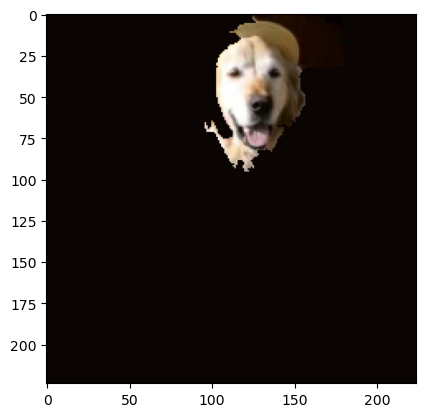

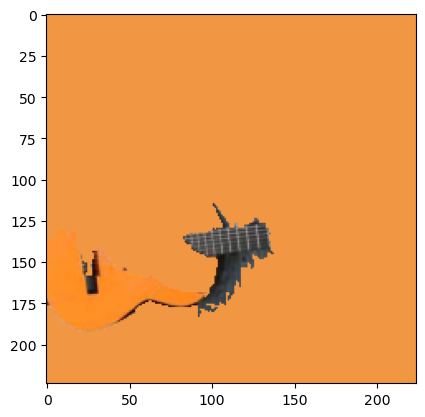

In [ ]:
# Attribution by SLIC+shap_sampler+single_color_perturbation+SHAP

# Using TopVisualizer to find the 2 segments with the highest attribution score for labrador and guitar
# The other segments are then removed, showing only the top 2
top2_visualizer = TopVisualizer(k=2, perturber=gray_perturbation)
lab_shap_visual = top2_visualizer(lab_shaps, img, slic_gray_shap_pipeline.masks)
gui_shap_visual = top2_visualizer(gui_shaps, img, slic_gray_shap_pipeline.masks)

# Display the 2 segments with the higest attribution scores
plt.figure()
plt.imshow(lab_shap_visual)
plt.figure()
plt.imshow(gui_shap_visual)

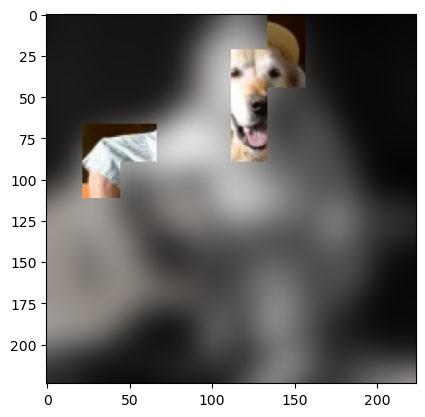

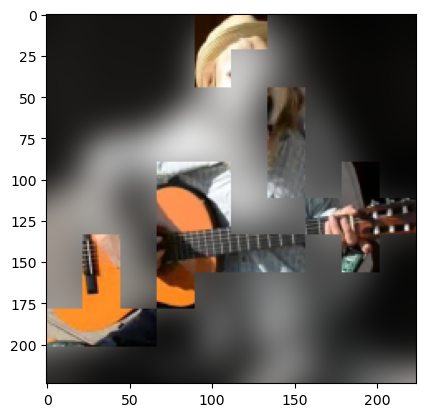

In [ ]:
# Attribution by grid+naive_ciu_sampler+blur perturbation+CIU

# Using TopVisualizer to visualize segments such that their combined attribution score is at least 30% of the total
top10percent_visualizer = TopVisualizer(p=0.3, perturber=blur_perturbation)
lab_ciu_visual = top10percent_visualizer(lab_infl, img, grid_blur_ciu_pipeline.masks)
gui_ciu_visual = top10percent_visualizer(gui_infl, img, grid_blur_ciu_pipeline.masks)

# Display the fewest segements that holds at least 30% of the attribution score
plt.figure()
plt.imshow(lab_ciu_visual)
plt.figure()
plt.imshow(gui_ciu_visual)

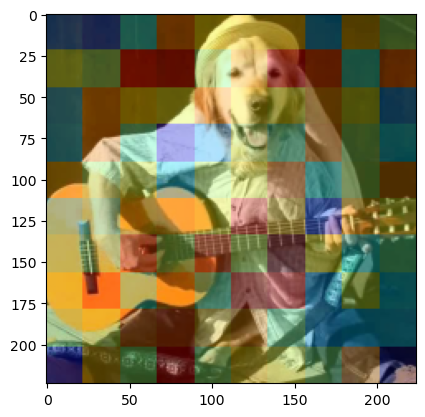

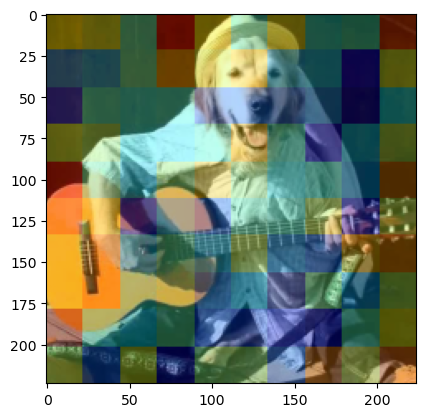

In [ ]:
# Attribution by faded grid+random_sampler+noisy perturbation+RISE

# Using HeatmapVisualizer to create a heatmap of the attribution score per segment
# The heatmap is then overlaid the original image to show the strength of attribution
heatmap_visualizer = HeatmapVisualizer(normalize=True, image_weight=0.7, invert_colormap=True)
lab_rise_visual = heatmap_visualizer(lab_rise, img, grid_noise_rise_pipeline.masks)
gui_rise_visual = heatmap_visualizer(gui_rise, img, grid_noise_rise_pipeline.masks)

# Display a heatmap of the segment attribution overlaid the original image
plt.figure()
plt.imshow(lab_rise_visual)
plt.figure()
plt.imshow(gui_rise_visual)

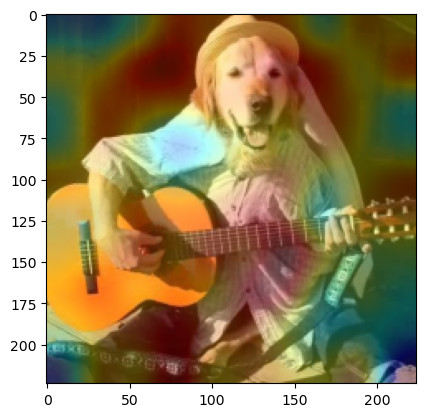

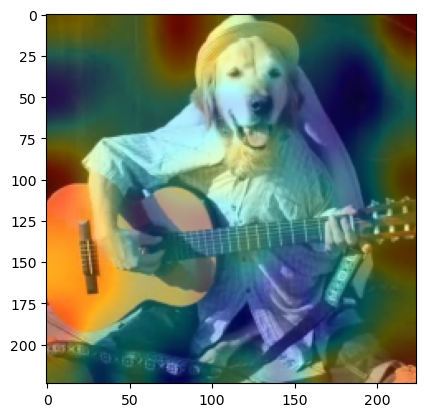

In [ ]:
# Pixel attribution by faded grid+random_sampler+noisy perturbation+RISE

# Since the RISE pipeline uses masks with gradients between 0 and 1 each pixel can be attributed individually
# This is done by assigning each pixel the attribution of each mask that overlaps it weighed by the mask value for that pixel
# This process works for any set of overlapping or gradient masks, but for RISE explanations it is equivalent to RISE attribution per pixel
lab_rise_pixels_visual = heatmap_visualizer(lab_rise, img, grid_noise_rise_pipeline.transformed_masks)
gui_rise_pixels_visual = heatmap_visualizer(gui_rise, img, grid_noise_rise_pipeline.transformed_masks)

# Display a heatmap of pixel attribution overlaid the original image
plt.figure()
plt.imshow(lab_rise_pixels_visual)
plt.figure()
plt.imshow(gui_rise_pixels_visual)

SLIC+shap_sampler+single_color_perturbation+SHAP	 7.1814375
grid+naive_ciu_sampler+blur perturbation+CIU		 5.3335085
grid+random_sampler+noisy perturbation+RISE		 2.5057116


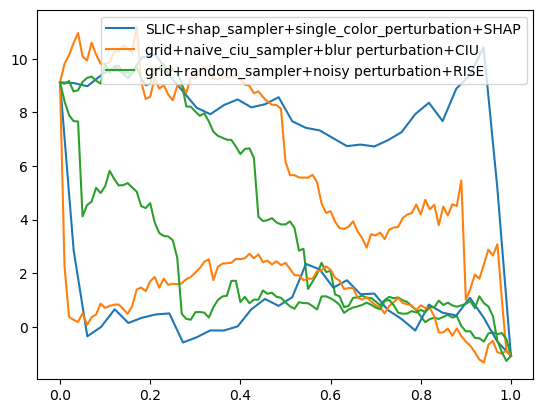

In [ ]:
# Calculate the insertion and deletion scores (AUC) of the explainations
# This is done by steadily inserting/deleting more of the image starting with the most
# attributed pixels.
# For insertion a better score is higher since it indicates that the impactful areas were inserted first
# The opposite gies for deletion, with lower scores indicating that the most impactful was deleted first

srg_evaluator = ImageAUCEvaluator(return_curves=True)
lab_shap_scores, lab_shap_curves = srg_evaluator(img, slic_gray_shap_pipeline.masks, model, lab_shaps, model_idxs=(...,0))
lab_ciu_scores, lab_ciu_curves = srg_evaluator(img, grid_blur_ciu_pipeline.masks, model, lab_infl, model_idxs=(...,0))
lab_rise_scores, lab_rise_curves = srg_evaluator(img, grid_noise_rise_pipeline.masks, model, lab_rise, model_idxs=(...,0))

# Print the SRG scores (insertion AUC - deletion AUC):
print('SLIC+shap_sampler+single_color_perturbation+SHAP\t', lab_shap_scores[-1])
print('grid+naive_ciu_sampler+blur perturbation+CIU\t\t', lab_ciu_scores[-1])
print('grid+random_sampler+noisy perturbation+RISE\t\t', lab_rise_scores[-1])

# Plot the insertion curves showing the prediction vs. the fraction of the image inserted/deleted
plt.plot(np.linspace(0,1,len(lab_shap_curves[0])), lab_shap_curves[0][::-1], c='C0')
plt.plot(np.linspace(0,1,len(lab_ciu_curves[0])), lab_ciu_curves[0][::-1], c='C1')
plt.plot(np.linspace(0,1,len(lab_rise_curves[0])), lab_rise_curves[0][::-1], c='C2')

# Plot the deletion curves showing the prediction vs. the fraction of the image inserted/deleted
plt.plot(np.linspace(0,1,len(lab_shap_curves[1])), lab_shap_curves[1], c='C0')
plt.plot(np.linspace(0,1,len(lab_ciu_curves[1])), lab_ciu_curves[1], c='C1')
plt.plot(np.linspace(0,1,len(lab_rise_curves[1])), lab_rise_curves[1], c='C2')
plt.legend((
    'SLIC+shap_sampler+single_color_perturbation+SHAP',
    'grid+naive_ciu_sampler+blur perturbation+CIU',
    'grid+random_sampler+noisy perturbation+RISE'
))